In [1]:
# Python packages
from itertools import chain

import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pickle
import signal
import argparse
import traceback
import json
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix

import pandas as pd

In [2]:
# sys.path.insert(1, "/home/ubuntu/pidgin-rl/model")
sys.path.insert(1, '../model')

from datasets import *
from decoder import *
from encoder_v2 import *
from train_encoder_v2 import *

# Load Data

In [3]:
LANG = "en"
# LANG = "fr"

In [4]:
BATCH_SIZE = 32

In [5]:
DATASET_PATH = '../generate-data/data_final/train/{}.csv'.format(LANG)
INDEXED_DATA_PATH = '../tokenizer/data_final/indexed_data_words.json' # dataset indexed
# TOKENIZED_DATA_PATH = "../tokenizer/data_final/tokens_words.json"
VOCAB_PATH = "../tokenizer/data_final/vocab_words.json"

In [6]:
dataset = pd.read_csv(DATASET_PATH).drop(columns=["Unnamed: 0"])
dataset.head()

,string,x,y
0,"move forty-eight to the left, then go down ten",-48,-10
1,go up eleven,0,11
2,move seventy-eight to the right and then go up...,78,20
3,move thirty-seven to the right then go down s...,37,-66
4,move seventy to the right and then go up sixt...,70,65


In [7]:
with open(VOCAB_PATH) as f:
  words = json.load(f)
words = pd.DataFrame.from_dict(words, orient='index', columns=["idx"]).reset_index()
words.drop(columns=["idx"], inplace=True)
words.rename(columns={"index":"label"}, inplace=True)
words.head()

,label
0,<pad>
1,<cls>
2,<eos>
3,allez
4,de


In [8]:
IX_TO_WORD = create_ix_to_vocab_map(VOCAB_PATH)

In [9]:
VOCAB_SIZE = len(words)

In [10]:
en_idx = [0, 1, 2, 6, 18, 19] + list(range(37, VOCAB_SIZE))
fr_idx = list(range(37))

In [11]:
{"<pad>": 0, "<cls>": 1, "<eos>": 2, "allez": 3, "de": 4, "cinquante": 5, "-": 6, "huit": 7, "\u00e0": 8, "droite": 9, "soixante": 10, "et": 11, "onze": 12, "gauche": 13, "puis": 14, "descendez": 15, "quatre": 16, "vingt": 17, "six": 18, ",": 19, "montez": 20, "quinze": 21, "trente": 22, "un": 23, "douze": 24, "neuf": 25, "quarante": 26, "dix": 27, "deux": 28, "sept": 29, "quatorze": 30, "vingts": 31, "cinq": 32, "trois": 33, "treize": 34, "seize": 35, "cent": 36, "move": 37, "forty": 38, "eight": 39, "to": 40, "the": 41, "left": 42, "then": 43, "go": 44, "down": 45, "ten": 46, "up": 47, "eleven": 48, "seventy": 49, "right": 50, "and": 51, "twenty": 52, "thirty": 53, "seven": 54, "sixty": 55, "five": 56, "nineteen": 57, "one": 58, "twelve": 59, "fifty": 60, "nine": 61, "eighty": 62, "three": 63, "ninety": 64, "two": 65, "seventeen": 66, "sixteen": 67, "four": 68, "fourteen": 69, "eighteen": 70, "fifteen": 71, "hundred": 72, "thirteen": 73}

{'<pad>': 0,
 '<cls>': 1,
 '<eos>': 2,
 'allez': 3,
 'de': 4,
 'cinquante': 5,
 '-': 6,
 'huit': 7,
 'à': 8,
 'droite': 9,
 'soixante': 10,
 'et': 11,
 'onze': 12,
 'gauche': 13,
 'puis': 14,
 'descendez': 15,
 'quatre': 16,
 'vingt': 17,
 'six': 18,
 ',': 19,
 'montez': 20,
 'quinze': 21,
 'trente': 22,
 'un': 23,
 'douze': 24,
 'neuf': 25,
 'quarante': 26,
 'dix': 27,
 'deux': 28,
 'sept': 29,
 'quatorze': 30,
 'vingts': 31,
 'cinq': 32,
 'trois': 33,
 'treize': 34,
 'seize': 35,
 'cent': 36,
 'move': 37,
 'forty': 38,
 'eight': 39,
 'to': 40,
 'the': 41,
 'left': 42,
 'then': 43,
 'go': 44,
 'down': 45,
 'ten': 46,
 'up': 47,
 'eleven': 48,
 'seventy': 49,
 'right': 50,
 'and': 51,
 'twenty': 52,
 'thirty': 53,
 'seven': 54,
 'sixty': 55,
 'five': 56,
 'nineteen': 57,
 'one': 58,
 'twelve': 59,
 'fifty': 60,
 'nine': 61,
 'eighty': 62,
 'three': 63,
 'ninety': 64,
 'two': 65,
 'seventeen': 66,
 'sixteen': 67,
 'four': 68,
 'fourteen': 69,
 'eighteen': 70,
 'fifteen': 71,
 'hundred':

# Load Model

Specifies the device, language, model type, and number of epochs, then loads in each checkpoint.

In [12]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

In [13]:
# Decoder or encoder
model_type = "encoder"
# model_type = "encoder"
N = 9 # last epoch we want

In [14]:
# N is the last epoch we want
MODEL_CHECKPOINTS = ["../model/saved_models/{}_{}/model_epoch_{}.pt".format(
    LANG, model_type, i) for i in range(1, N)]
MODELS = [torch.load(checkpoint, map_location=device) for checkpoint in MODEL_CHECKPOINTS]
EMBEDS = [list(model.children())[:-1][0] for model in MODELS]

/home/ubuntu/miniconda3/envs/9190/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'encoder_v2.Sequence_Generator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/miniconda3/envs/9190/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'encoder_v2.Decoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/miniconda3/envs/9190/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'encoder_v2.FC_Encoder' has changed. you can retrieve the original source code by accessi

In [15]:
embed = EMBEDS[-1]

In [16]:
to_embed = torch.tensor(range(VOCAB_SIZE), dtype=torch.long, device=device)
embeddings = embed(to_embed).cpu().detach().numpy()
pd.DataFrame(embeddings)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.180772,-0.069988,-0.359623,-0.915204,0.625765,0.025510,0.954514,0.064349,0.361151,1.167878,-1.349893,-0.510177,0.235958,-0.239778,-0.921115,1.543297,1.348826,-0.139642,0.285797,0.965120
1,-0.007221,0.008710,0.019610,0.006379,-0.014562,-0.275112,-0.001091,-0.020096,0.000555,-0.000384,0.353891,0.842685,0.002011,0.003046,0.000217,0.003101,0.003104,-0.009333,-0.009989,0.008432
2,0.497470,-0.469363,0.352317,-0.579164,-1.047815,0.040459,-0.085212,-0.551897,0.423254,-0.132269,0.564611,-0.439652,-0.358194,1.557804,1.896857,-0.784709,0.452061,-0.903900,-0.839343,0.262646
3,0.778898,1.533269,1.609736,-0.403228,-0.834470,0.597801,-0.051406,-0.064559,-0.497006,0.465756,-0.257259,-1.067259,2.008941,-0.536977,0.222799,0.697055,-1.426664,0.905942,0.144595,0.228000
4,2.489964,-1.223671,1.010669,0.555996,-1.593490,-1.270646,0.690326,-0.196135,0.344914,-0.341886,0.475872,-0.766340,-0.418963,-0.436995,-1.001207,-0.409428,-1.666937,-1.365144,-0.165524,0.962252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,-0.336357,0.351001,-0.099223,1.063945,-0.716028,0.261641,0.362091,0.241303,0.162815,-0.143089,0.288427,0.161948,0.210524,0.205593,0.454216,0.111162,0.545875,0.596191,1.168127,0.325914
70,0.135164,0.349930,-0.372530,0.210221,0.799506,0.858142,1.725406,1.300518,-0.253609,0.159499,0.353444,-0.573854,1.011494,0.330968,1.074434,1.142427,0.645851,0.631029,1.727284,0.652332
71,0.206677,0.595225,-0.058432,0.816459,-0.288115,0.163605,0.224900,0.226449,0.221983,-0.186916,0.189888,-0.054687,0.588171,-0.059145,0.796461,-0.191467,0.061859,0.125999,1.013623,0.783365
72,0.537945,1.352092,0.734818,1.099742,-0.500368,-1.080919,-0.417377,-1.017117,-0.098263,1.825088,0.253161,-0.588042,1.469431,1.718101,0.269216,0.003609,1.011682,0.229366,0.446779,-0.345635


In [17]:
words = pd.concat([words, pd.DataFrame(embeddings)], axis=1)
words

,label,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,<pad>,0.180772,-0.069988,-0.359623,-0.915204,0.625765,0.025510,0.954514,0.064349,0.361151,...,-1.349893,-0.510177,0.235958,-0.239778,-0.921115,1.543297,1.348826,-0.139642,0.285797,0.965120
1,<cls>,-0.007221,0.008710,0.019610,0.006379,-0.014562,-0.275112,-0.001091,-0.020096,0.000555,...,0.353891,0.842685,0.002011,0.003046,0.000217,0.003101,0.003104,-0.009333,-0.009989,0.008432
2,<eos>,0.497470,-0.469363,0.352317,-0.579164,-1.047815,0.040459,-0.085212,-0.551897,0.423254,...,0.564611,-0.439652,-0.358194,1.557804,1.896857,-0.784709,0.452061,-0.903900,-0.839343,0.262646
3,allez,0.778898,1.533269,1.609736,-0.403228,-0.834470,0.597801,-0.051406,-0.064559,-0.497006,...,-0.257259,-1.067259,2.008941,-0.536977,0.222799,0.697055,-1.426664,0.905942,0.144595,0.228000
4,de,2.489964,-1.223671,1.010669,0.555996,-1.593490,-1.270646,0.690326,-0.196135,0.344914,...,0.475872,-0.766340,-0.418963,-0.436995,-1.001207,-0.409428,-1.666937,-1.365144,-0.165524,0.962252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,fourteen,-0.336357,0.351001,-0.099223,1.063945,-0.716028,0.261641,0.362091,0.241303,0.162815,...,0.288427,0.161948,0.210524,0.205593,0.454216,0.111162,0.545875,0.596191,1.168127,0.325914
70,eighteen,0.135164,0.349930,-0.372530,0.210221,0.799506,0.858142,1.725406,1.300518,-0.253609,...,0.353444,-0.573854,1.011494,0.330968,1.074434,1.142427,0.645851,0.631029,1.727284,0.652332
71,fifteen,0.206677,0.595225,-0.058432,0.816459,-0.288115,0.163605,0.224900,0.226449,0.221983,...,0.189888,-0.054687,0.588171,-0.059145,0.796461,-0.191467,0.061859,0.125999,1.013623,0.783365
72,hundred,0.537945,1.352092,0.734818,1.099742,-0.500368,-1.080919,-0.417377,-1.017117,-0.098263,...,0.253161,-0.588042,1.469431,1.718101,0.269216,0.003609,1.011682,0.229366,0.446779,-0.345635


# Dimension reduction and Plotting

In [18]:
def PCA_(n, df):
    """
    PCAs df into n-dimensional df. Centers data automatically
    """
    pca = PCA(n_components=n)
    pca_df = pd.DataFrame(pca.fit_transform(np.array(df)))
    print('PCAed into shape: ', pca_df.shape)
    return pca_df

In [19]:
def tSNE(df):
    """
    t-SNEs df into 2 dimensions for visualization
    """
    X_embed = TSNE(n_components=2).fit_transform(df)
    print('t-SNEd into shape:', X_embed.shape)

    return X_embed

In [20]:
def plot_embeds(embeds, names, title='tSNE Visualization of Embeddings'):
    """
    Plots embeddings with their corresponding names.

    embeds: N x 2 df where N[i] is a point to plot and names[i] is the corresponding label

    """
    embeds = np.array(embeds)
    for i, embed in enumerate(embeds):
        plt.scatter(embed[0], embed[1])
        plt.text(embed[0] + 0.05, embed[1] - 0.07, names[i], fontsize=9)

    plt.title(title)
    plt.show()

In [21]:
# SPLIT DATASET INTO ENGLISH/FRENCH
to_pca = words[words.columns.tolist()[1:]]
to_pca_en = to_pca.iloc[en_idx, :]
to_pca_fr = to_pca.iloc[fr_idx, :]

to_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.180772,-0.069988,-0.359623,-0.915204,0.625765,0.025510,0.954514,0.064349,0.361151,1.167878,-1.349893,-0.510177,0.235958,-0.239778,-0.921115,1.543297,1.348826,-0.139642,0.285797,0.965120
1,-0.007221,0.008710,0.019610,0.006379,-0.014562,-0.275112,-0.001091,-0.020096,0.000555,-0.000384,0.353891,0.842685,0.002011,0.003046,0.000217,0.003101,0.003104,-0.009333,-0.009989,0.008432
2,0.497470,-0.469363,0.352317,-0.579164,-1.047815,0.040459,-0.085212,-0.551897,0.423254,-0.132269,0.564611,-0.439652,-0.358194,1.557804,1.896857,-0.784709,0.452061,-0.903900,-0.839343,0.262646
3,0.778898,1.533269,1.609736,-0.403228,-0.834470,0.597801,-0.051406,-0.064559,-0.497006,0.465756,-0.257259,-1.067259,2.008941,-0.536977,0.222799,0.697055,-1.426664,0.905942,0.144595,0.228000
4,2.489964,-1.223671,1.010669,0.555996,-1.593490,-1.270646,0.690326,-0.196135,0.344914,-0.341886,0.475872,-0.766340,-0.418963,-0.436995,-1.001207,-0.409428,-1.666937,-1.365144,-0.165524,0.962252


PCAed into shape:  (43, 2)
PCAed into shape:  (37, 2)


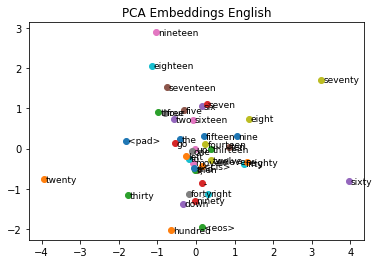

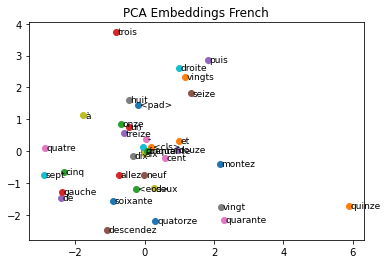

In [22]:
# PCA
pcaed_en = PCA_(2, to_pca_en)
pcaed_fr = PCA_(2, to_pca_fr)
plot_embeds(pcaed_en, list(words.iloc[en_idx,:]['label']), title="PCA Embeddings English")
plot_embeds(pcaed_fr, words.iloc[fr_idx,:]['label'], title="PCA Embeddings French")

t-SNEd into shape: (43, 2)
t-SNEd into shape: (37, 2)


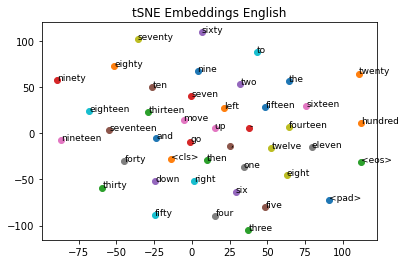

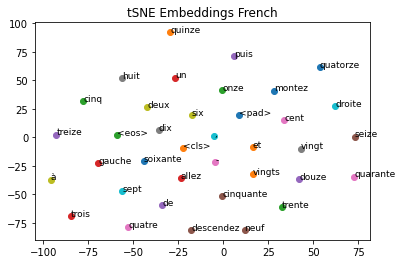

In [23]:
# TSNE
tsed_en = tSNE(to_pca_en)
tsned_fr = tSNE(to_pca_fr)
plot_embeds(tsed_en, list(words.iloc[en_idx,:]['label']), title="tSNE Embeddings English")
plot_embeds(tsned_fr, words.iloc[fr_idx,:]['label'], title="tSNE Embeddings French")

# Distance matrix

In [24]:
def plot_matrix(mat, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(mat)
    plt.title(title)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes, {'fontsize': 7})
    ax.set_yticklabels(classes, {'fontsize': 7})

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.colorbar(im)
    plt.show()

def vis_distance_matrix(df, classes, title, cos=True):
    """
    Visualize pairwise cosine distances between rows of the df.
    df should be a pandas dataframe of embedding vectors.
    """
    embeds = np.array(df)

    if cos:
        embeds = normalize(embeds, norm='l2', axis=1, copy=True, return_norm=False)
    dists = distance_matrix(embeds, embeds, p=2)
    
    plot_matrix(dists, classes, title)

    return dists


# Sentence Generation (run only if encoder)

In [304]:
def get_perplexity(loss):
    """
    loss: per-word loss from evaluation
    A perplexity of random guessing is vocab size = 74. Anything lower is extremely good.
    """
    return math.exp(loss)

In [99]:
# Load english data set
iters = load_data(DATASET_PATH, INDEXED_DATA_PATH, LANG, BATCH_SIZE, device)
_, _, en_test_iter = iters
print('Finished loading ENGLISH data')

# Load french dataset
iters = load_data('../generate-data/data_final/train/fr.csv', INDEXED_DATA_PATH, 'fr', BATCH_SIZE, device)
X_str, train_iter, fr_test_iter = iters
print('Finished loading FRENCH data')

Loading data...
Finished loading ENGLISH data
Loading data...
Finished loading FRENCH data


In [28]:
from train_jointly import evaluate as joint_eval

In [109]:
# Load in models over time
def get_checkpoints(model_dir = '../model/saved_models/en'):
    '''
    Load in all model checkpoints, save as dict
    '''
    checkpoints = {}
    for file in os.listdir(model_dir):
        end = file.split('_')[-1]
        if len(end) == 4: epoch_num = end[0]
        else: epoch_num = end[:2]
        model_path = os.path.join(model_dir, file)
        checkpoints[epoch_num] = torch.load(model_path)
    return checkpoints

In [110]:
# Get english and french checkpoints
# Monolingual 
en_checkpoints = get_checkpoints()
fr_checkpoints = get_checkpoints('../model/saved_models/fr')

# Transfer learned 
en_transfer_checkpoints = get_checkpoints('../model/saved_models/en_transfer')
fr_transfer_checkpoints = get_checkpoints('../model/saved_models/fr_transfer')

In [273]:
def eval_checkpoints(checkpoints, data, device):
    '''
    Evaluate model checkpoints using provide data
    '''
    LOSSES = []
    for c_ix in range(1, len(checkpoints)+1):
        model = checkpoints[str(c_ix)]
        dec_criterion = nn.MSELoss()
        enc_criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
        loss = joint_eval(model, data, enc_criterion, dec_criterion, device, args=None, type='Test')
        LOSSES.append(loss)
        print(f"Loss for epoch {c_ix}: {loss}",flush=True,end='\r')
    return LOSSES

In [274]:
en_losses_on_english = eval_checkpoints(en_checkpoints, en_test_iter, device)

[Batch]: 1998/1999 in 0.01825 seconds
[Batch]: 1998/1999 in 0.02458 seconds 6.549796494981973e-05)
[Batch]: 1998/1999 in 0.01973 seconds, 5.2004488831879034e-05)
[Batch]: 1998/1999 in 0.02283 seconds 4.0716019910866726e-05)
[Batch]: 1998/1999 in 0.01852 seconds 3.8760351432967845e-05)
[Batch]: 1998/1999 in 0.01936 seconds 5.1906889268675096e-05)
[Batch]: 1998/1999 in 0.01936 seconds 3.515141759689612e-05)
[Batch]: 1998/1999 in 0.01989 seconds, 3.114980056069862e-05)
[Batch]: 1998/1999 in 0.01849 seconds, 2.1765495077331777e-05)
[Batch]: 1998/1999 in 0.01819 seconds2.0812412282171493e-05)
[Batch]: 1998/1999 in 0.01855 seconds3, 1.885980947850483e-05)
[Batch]: 1998/1999 in 0.01889 seconds5, 1.6724524619104487e-05)
[Batch]: 1998/1999 in 0.01907 seconds7, 1.9053065568524597e-05)
[Batch]: 1998/1999 in 0.01891 seconds5, 2.4431392323824544e-05)
[Batch]: 1998/1999 in 0.01981 seconds, 1.3004913646250459e-05)


In [275]:
fr_losses_on_french = eval_checkpoints(fr_checkpoints, fr_test_iter, device)

[Batch]: 1998/1999 in 0.01947 seconds
[Batch]: 1998/1999 in 0.02579 seconds, 0.0001894959793026407)
[Batch]: 1998/1999 in 0.02831 seconds 8.983131102007772e-05)
[Batch]: 1998/1999 in 0.01896 seconds, 6.12587518104067e-05)
[Batch]: 1998/1999 in 0.01951 seconds 3.9552752955865365e-05)
[Batch]: 1998/1999 in 0.01921 seconds, 3.655851549134222e-05)
[Batch]: 1998/1999 in 0.01971 seconds 3.292852027648091e-05)
[Batch]: 1998/1999 in 0.02473 seconds 2.759714549724435e-05)
[Batch]: 1998/1999 in 0.03044 seconds 2.1078953959166866e-05)
[Batch]: 1998/1999 in 0.02913 seconds 2.1704053883448302e-05)
[Batch]: 1998/1999 in 0.02011 seconds4, 1.753021627042768e-05)
[Batch]: 1998/1999 in 0.02740 seconds, 1.779060393473988e-05)
[Batch]: 1998/1999 in 0.01939 seconds5, 1.5429780750290005e-05)
[Batch]: 1998/1999 in 0.02699 seconds5, 1.7202635028199417e-05)
[Batch]: 1998/1999 in 0.01949 seconds, 1.470694306715022e-05)


In [276]:
en_transfer_en = eval_checkpoints(en_transfer_checkpoints, en_test_iter, device)

[Batch]: 1998/1999 in 0.01946 seconds
[Batch]: 1998/1999 in 0.01884 seconds, 7.727628596966258e-05)
[Batch]: 1998/1999 in 0.01986 seconds 7.681288929677065e-05)
[Batch]: 1998/1999 in 0.01875 seconds 4.978919295313852e-05)
[Batch]: 1998/1999 in 0.02183 seconds 2.9249184530188975e-05)
[Batch]: 1998/1999 in 0.01885 seconds, 2.3988186185610323e-05)
[Batch]: 1998/1999 in 0.01843 seconds 5.372046261826897e-05)
[Batch]: 1998/1999 in 0.03032 seconds 2.1418943181353667e-05)
[Batch]: 1998/1999 in 0.01925 seconds, 2.0404078502458457e-05)
[Batch]: 1998/1999 in 0.01903 seconds, 1.5420817602438834e-05)
[Batch]: 1998/1999 in 0.01865 seconds, 1.4993036463825125e-05)
[Batch]: 1998/1999 in 0.01919 seconds, 1.858747268248635e-05)
[Batch]: 1998/1999 in 0.01880 seconds, 1.2677219162613895e-05)
[Batch]: 1998/1999 in 0.02395 seconds, 1.7872329010208696e-05)
[Batch]: 1998/1999 in 0.01894 seconds, 1.6623780983147093e-05)


In [277]:
en_transfer_fr = eval_checkpoints(en_transfer_checkpoints, fr_test_iter, device)

[Batch]: 1998/1999 in 0.01925 seconds
[Batch]: 1998/1999 in 0.01914 seconds 0.2993488149644628)
[Batch]: 1998/1999 in 0.01919 seconds 0.3222534164565532)
[Batch]: 1998/1999 in 0.01980 seconds0.3319512217575442)
[Batch]: 1998/1999 in 0.01943 seconds 0.3187009633180651)
[Batch]: 1998/1999 in 0.01922 seconds 0.33762507809747716)
[Batch]: 1998/1999 in 0.01928 seconds 0.33895811521656255)
[Batch]: 1998/1999 in 0.02006 seconds 0.3527776512566697)
[Batch]: 1998/1999 in 0.02747 seconds, 0.3724700019061746)
[Batch]: 1998/1999 in 0.02108 seconds 0.36647579908630806)
[Batch]: 1998/1999 in 0.01905 seconds, 0.3717166337886531)
[Batch]: 1998/1999 in 0.01928 seconds, 0.36895482248522754)
[Batch]: 1998/1999 in 0.01947 seconds5, 0.36508850144905874)
[Batch]: 1998/1999 in 0.02036 seconds 0.3760625461103033)
[Batch]: 1998/1999 in 0.01912 seconds, 0.37786826692124803)


In [278]:
fr_transfer_fr = eval_checkpoints(fr_transfer_checkpoints, fr_test_iter, device)

[Batch]: 1998/1999 in 0.01895 seconds
[Batch]: 1998/1999 in 0.01912 seconds0.000134393226615198)
[Batch]: 1998/1999 in 0.01923 seconds 7.849296676436484e-05)
[Batch]: 1998/1999 in 0.01930 seconds 5.8531616667725726e-05)
[Batch]: 1998/1999 in 0.01914 seconds 4.043820694368316e-05)
[Batch]: 1998/1999 in 0.01937 seconds 3.305245972339809e-05)
[Batch]: 1998/1999 in 0.01944 seconds 2.8111923674844506e-05)
[Batch]: 1998/1999 in 0.01895 seconds, 3.242314304310288e-05)
[Batch]: 1998/1999 in 0.02734 seconds, 2.628471505727154e-05)
[Batch]: 1998/1999 in 0.01907 seconds, 2.3953460884386742e-05)
[Batch]: 1998/1999 in 0.02059 seconds3, 2.080346394548449e-05)
[Batch]: 1998/1999 in 0.03290 seconds3, 1.7886462999127804e-05)
[Batch]: 1998/1999 in 0.02283 seconds7, 2.04769209076784e-05)
[Batch]: 1998/1999 in 0.01991 seconds, 1.8414468095819373e-05)
[Batch]: 1998/1999 in 0.01913 seconds, 1.5767817586548322e-05)


In [279]:
fr_transfer_en = eval_checkpoints(fr_transfer_checkpoints, en_test_iter, device)

[Batch]: 1998/1999 in 0.01916 seconds
[Batch]: 1998/1999 in 0.01900 seconds0.41927177590398973)
[Batch]: 1998/1999 in 0.01963 seconds, 0.3784582291084126)
[Batch]: 1998/1999 in 0.01844 seconds 0.36272957385737176)
[Batch]: 1998/1999 in 0.01876 seconds 0.36958935820918093)
[Batch]: 1998/1999 in 0.01814 seconds 0.3815268863813695)
[Batch]: 1998/1999 in 0.01932 seconds 0.38191831295794987)
[Batch]: 1998/1999 in 0.02051 seconds 0.3856863589391287)
[Batch]: 1998/1999 in 0.01937 seconds 0.3813364490845085)
[Batch]: 1998/1999 in 0.01929 seconds 0.36487259621964896)
[Batch]: 1998/1999 in 0.01979 seconds, 0.37825468697906034)
[Batch]: 1998/1999 in 0.03233 seconds 0.3994754936279372)
[Batch]: 1998/1999 in 0.01864 seconds, 0.4001856568680069)
[Batch]: 1998/1999 in 0.01876 seconds, 0.42170437069583083)
[Batch]: 1998/1999 in 0.01966 seconds, 0.4116920235121522)


### Encoder per work perlexity over time

In [280]:
import seaborn as sns

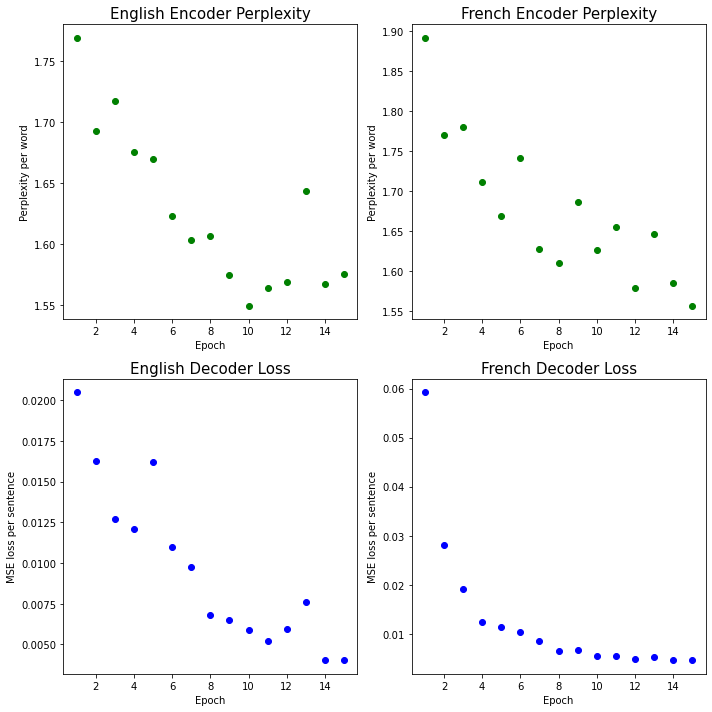

In [323]:
# Plot monolingual perplexities
# -----------------------------
en_mono_enc = [get_perplexity(l[0]/(32*24)) for l in en_losses_on_english]
fr_mono_enc = [get_perplexity(l[0]/(32*24)) for l in fr_losses_on_french]

en_mono_dec = [l[1]*(100**2)/(32) for l in en_losses_on_english]
fr_mono_dec = [l[1]*(100**2)/(32) for l in fr_losses_on_french]

# plot everything together
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0][0].scatter(range(1,16), en_mono_enc, c='g')
axs[0][0].set_title('English Encoder Perplexity',size=15)

axs[0][1].scatter(range(1,16), fr_mono_enc, c='g')
axs[0][1].set_title('French Encoder Perplexity',size=15)

axs[1][0].scatter(range(1,16), en_mono_dec, c='b')
axs[1][0].set_title('English Decoder Loss',size=15)

axs[1][1].scatter(range(1,16), fr_mono_dec, c='b')
axs[1][1].set_title('French Decoder Loss',size=15)

for i in range(2):
    axs[0][i].set(xlabel='Epoch', ylabel='Perplexity per word')
    axs[1][i].set(xlabel='Epoch', ylabel='MSE loss per sentence')
    
plt.tight_layout()


In [310]:
n = len(train_iter[0])

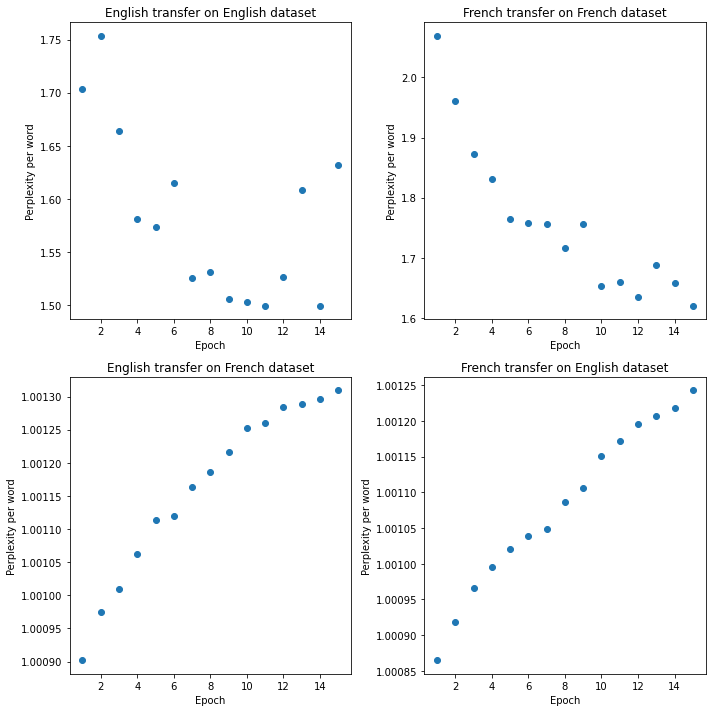

In [314]:
# Plot transfer learning perplexities
# -----------------------------
# evalauted on original languages
en_transfer_en_perp = [get_perplexity(l[0]/(32*24)) for l in en_transfer_en]
fr_transfer_fr_perp = [get_perplexity(l[0]/(32*24)) for l in fr_transfer_fr]

# evaluated on second languages
en_transfer_fr_perp = [get_perplexity(l[0]/(32*24*n)) for l in en_transfer_fr]
fr_transfer_en_perp = [get_perplexity(l[0]/(32*24*n)) for l in fr_transfer_en]


# plot everything together
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0][0].scatter(range(1,16), en_transfer_en_perp,c='')
axs[0][0].set_title('English transfer on English dataset')

axs[0][1].scatter(range(1,16), fr_transfer_fr_perp,c='')
axs[0][1].set_title('French transfer on French dataset')

axs[1][0].scatter(range(1,16), en_transfer_fr_perp)
axs[1][0].set_title('English transfer on French dataset')

axs[1][1].scatter(range(1,16), fr_transfer_en_perp)
axs[1][1].set_title('French transfer on English dataset')

for ax in axs.flatten():
    ax.set(xlabel='Epoch', ylabel='Perplexity per word');

    
plt.tight_layout()

In [ ]:
# Decoder loss over time

In [ ]:
# Plot decoder losses during after transfer learning
# --------------------------
# evalauted on original languages
en_transfer_en_dec_loss = [l[1]*(100**2)/(32) for l in en_transfer_en]
fr_transfer_fr_dec_loss = [l[1]*(100**2)/(32) for l in fr_transfer_fr]

# evaluated on second languages
en_transfer_fr_dec_loss = [l[1]*(100**2)/(32) for l in en_transfer_fr]
fr_transfer_en_dec_loss = [l[1]*(100**2)/(32) for l in fr_transfer_en]

# plot everything together
fig, axs = plt.subplots(2, 2, figsize=(5,5))
axs[0][0].scatter(range(1,10), en_transfer_en_dec_loss)
axs[0][0].set_title('English transfer on English dataset')

axs[0][1].scatter(range(1,10), fr_transfer_fr_dec_loss)
axs[0][1].set_title('French transfer on French dataset')

axs[1][0].scatter(range(1,10), en_transfer_fr_dec_loss)
axs[1][0].set_title('English transfer on French dataset')

axs[1][1].scatter(range(1,10), fr_transfer_en_dec_loss)
axs[1][1].set_title('French transfer on English dataset')

for ax in axs.flatten():
    axs.set(xlabel='Epoch', ylabel='MSE loss per sentence');

In [ ]:
# Sentence analysis
def produce_example_sentences(checkpoints, data, ix_to_word, device, time_pts=[1,7,15]):
    '''
    Shows a model's predictions on the same sentences over time
    '''
    ix = np.random.randint(len(data[0]))
    for t in time_pts:
        model = checkpoints[str(t)]
        output = model.forward_encoder(data[2][ix].float().to(device))
        pred_sentences = translate_batch(output, ix_to_word)
        yield (data[2][ix], pred_sentences)


In [287]:
def select_first(checkpoints, data, ix_to_word, device, first=5):
    examples = produce_example_sentences(checkpoints, data, ix_to_word, device)
    for ix, batch in enumerate(examples):
        for s_ix, val in enumerate(batch[0][:first]):
            print(batch[0][s_ix].cpu().numpy(), ' '.join(batch[1][s_ix][:15]))
        print()
#         for s_ix, sentence in enumerate(batch[:5]):
#             print(coord[ix][s_ix], sentence[:15])
#         print()

In [288]:
# Monolingual English
select_first(en_checkpoints, en_test_iter, IX_TO_WORD, device, first=3)

[ 0.02 -0.74] <cls> go down seventy - right and then go down - - <eos> <eos> <eos>
[0.73 0.81] <cls> move seventy - three to the right then then go up eighty - <eos>
[ 0.17 -0.07] <cls> move seventeen to the right , then go down <eos> <eos> <eos> <eos> <eos>

[ 0.02 -0.74] <cls> go down to the right then then go down seventy - <eos> <eos> <eos>
[0.73 0.81] <cls> move seventy - two to the right then then go up - - <eos>
[ 0.17 -0.07] <cls> move seventeen to the right , then go down <eos> <eos> <eos> <eos> <eos>

[ 0.02 -0.74] <cls> move three to the right , then go down seventy - <eos> <eos> <eos>
[0.73 0.81] <cls> move seventy - three to the right then then go up eighty - <eos>
[ 0.17 -0.07] <cls> move seventeen to the right then then go down <eos> <eos> <eos> <eos> <eos>



In [289]:
# Monolingual French
select_first(fr_checkpoints, fr_test_iter, IX_TO_WORD, device, first=3)

[-0.64  0.95] <cls> allez de soixante - gauche à gauche et puis montez de quatre - vingt
[-0.83  0.  ] <cls> allez de quatre - vingt - neuf à gauche <eos> puis de de un
[0.93 0.16] <cls> allez de quatre - vingt - neuf à droite et puis montez de dix

[-0.64  0.95] <cls> allez de soixante - quatre à gauche et puis montez de quatre - vingt
[-0.83  0.  ] <cls> allez de quatre - vingt - deux à gauche <eos> puis de de un
[0.93 0.16] <cls> allez de quatre - vingt - quatorze à droite , puis montez de <eos>

[-0.64  0.95] <cls> allez de soixante - quatre à gauche , puis montez de quatre - vingt
[-0.83  0.  ] <cls> allez de quatre - vingt - deux à gauche <eos> puis de de <eos>
[0.93 0.16] <cls> allez de quatre - vingt - douze à droite puis puis montez de <eos>



In [290]:
# Transfer French on french
select_first(fr_transfer_checkpoints, fr_test_iter, IX_TO_WORD, device, first=3)

[-0.39  0.27] <cls> allez de trente - neuf à gauche , puis montez de - - <eos>
[ 0.46 -0.6 ] <cls> allez de quarante - huit à droite et puis descendez de - - <eos>
[-0.14  0.87] <cls> allez de dix à gauche puis puis montez de - - <eos> <eos> <eos>

[-0.39  0.27] <cls> allez de trente - neuf à gauche puis puis montez de - - <eos>
[ 0.46 -0.6 ] <cls> allez de quarante - six à droite puis puis descendez de soixante - <eos>
[-0.14  0.87] <cls> allez de quatorze à gauche puis puis montez de quatre - vingt - <eos>

[-0.39  0.27] <cls> allez de trente - neuf à gauche puis puis montez de vingt - <eos>
[ 0.46 -0.6 ] <cls> allez de quarante - six à droite , puis descendez de cinquante - <eos>
[-0.14  0.87] <cls> allez de quatorze à gauche puis puis montez de quatre - vingt - <eos>



In [291]:
# Transfer French on English
select_first(fr_transfer_checkpoints, en_test_iter, IX_TO_WORD, device, first=3)

[0.87 0.11] <cls> allez de quatre - vingt - quatre à droite <eos> puis montez de -
[ 0.   -0.92] <cls> descendez de quatre - vingt - dix <eos> de <eos> <eos> <eos> <eos> <eos>
[0.33 0.19] <cls> allez de trente - quatre à droite <eos> puis montez de - - <eos>

[0.87 0.11] <cls> allez de quatre - vingt - sept à droite et puis montez de <eos>
[ 0.   -0.92] <cls> descendez de quatre - vingt - neuf <eos> de quatre vingt quatre quatre vingt
[0.33 0.19] <cls> allez de trente - quatre à droite puis puis montez de vingt - <eos>

[0.87 0.11] <cls> allez de quatre - vingt - sept à droite et puis montez de <eos>
[ 0.   -0.92] <cls> descendez de quatre - vingt - dix <eos> sept <eos> de - - vingt
[0.33 0.19] <cls> allez de trente - deux à droite et puis montez de vingt - <eos>



In [292]:
# Transfer English on English
select_first(en_transfer_checkpoints, en_test_iter, IX_TO_WORD, device, first=3)

[0.71 0.91] <cls> move seventy - three to the right then then go up - - <eos>
[ 0.89 -0.25] <cls> move eighty - eight to the right then then go down twenty - <eos>
[-0.1   0.03] <cls> move thirteen to the left then then go up <eos> <eos> three <eos> <eos>

[0.71 0.91] <cls> move seventy - two to the right then then go up - - <eos>
[ 0.89 -0.25] <cls> move eighty - eight to the right then then go down twenty - <eos>
[-0.1   0.03] <cls> move ten to the left then then go up three <eos> two <eos> <eos>

[0.71 0.91] <cls> move seventy - one to the right , then go up ninety - <eos>
[ 0.89 -0.25] <cls> move eighty - nine to the right , then go down twenty - five
[-0.1   0.03] <cls> move ten to the left , then go up four <eos> <eos> <eos> <eos>



In [293]:
# Transfer English on French
select_first(en_transfer_checkpoints, fr_test_iter, IX_TO_WORD, device, first=3)

[-0.5   0.31] <cls> move fifty - one to the left go then go up - - <eos>
[0.67 0.  ] <cls> move sixty - eight to the right <eos> then go down one <eos> <eos>
[ 0.94 -0.9 ] <cls> move ninety - three to the right then then go down - - <eos>

[-0.5   0.31] <cls> move fifty - the left the left go up go - thirty - <eos>
[0.67 0.  ] <cls> move sixty - seven to the right <eos> then go one one <eos> <eos>
[ 0.94 -0.9 ] <cls> move ninety - three to the right , then go down - - <eos>

[-0.5   0.31] <cls> move forty - seven to the left then then go up thirty - <eos>
[0.67 0.  ] <cls> move sixty - seven to the right <eos> then go up <eos> <eos> one
[ 0.94 -0.9 ] <cls> move ninety - four to the right , then go down - - <eos>

